# GTSRB Dataset
This dataset is a collection of images sorted by types of Traffic signals. 
This dataset is made available by the German Trafific Department.

## Info
This document is written in a IPynB file. This file can be copied and used by anybody for any use whatsoever. For corrections and other doubts there is my contact information
Author: pspiagicw
Email: pspiagicw@gmail.com

## System Information
This document is written in a Arch Linux System. The prerequisites includes
* Python
* Jupyter Notebook or Jupyter Lab . Modern editors like Emacs , VSCode also support .IPYNB Files
* Tensorflow and Keras(Keras included by default in newer TensorFlow installation)
* The GTSRB Dataset 
  The current source of the dataset is from 'Kaggle Datasets'.You can also obtain from other sources.
  The currently obtained dataset is divided into two folders (train and test). The train folder contains subfolders representing different types of traffic signs. There is a `Train.csv` file but it is not used for training as it is already divided into subfolders.
  The testing directory in the current source is not segregated by directories but a simple Python Script is used with
  the given `Test.csv` file. 
* (Optional) CUDA and CUDADNN installation. This is only possible if NVIDIA GPU is available.Makes training faster.

In [1]:
import os
os.listdir('data')
# `custom_test_dir` not in original dataset. Read further to know more.

['Train.csv',
 'Train',
 'train',
 'Test',
 'Meta.csv',
 'custom_test_dir',
 'test',
 'meta',
 'Meta',
 'archive.zip',
 'Test.csv']

In [31]:
# This is to show the list of dataset
# This returns a list of directories! (Truncated here)
import os
os.listdir('data/train')[:10]

['39', '37', '16', '17', '13', '21', '7', '18', '22', '15']

In [32]:
# Lising of '39' directory inside 'data/train'
os.listdir('data/train/39')[:10]

['00039_00002_00024.png',
 '00039_00005_00020.png',
 '00039_00000_00002.png',
 '00039_00008_00013.png',
 '00039_00009_00023.png',
 '00039_00008_00016.png',
 '00039_00003_00015.png',
 '00039_00003_00018.png',
 '00039_00003_00000.png',
 '00039_00009_00012.png']

In [33]:
import tensorflow as tf
# We aer using tensorflow here , as it is a image classification problem. With image classification problem standard machine learning algorithms takes a lot of time and can't find convoluted non-linear relations.
# This is the reason we are jumping to Neural Network. Using CNN makes sense in a Image Classifcation problem , also we can use our GPU to speed up the learning part.

Random Image for inspection!

(86, 82, 3)


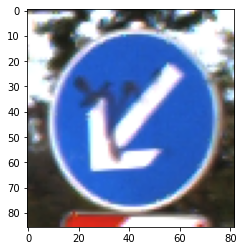

In [34]:
import matplotlib.pyplot as plt
img = plt.imread('data/train/39/00039_00002_00024.png')
plt.imshow(img)
print(img.shape)

In [35]:
# Custom function for displaying 10 images in a grid. Useful for data exploration.
def show_images(name):
    images = [os.path.join('data/train/'+name , directory) for directory in os.listdir('data/train/'+name)[:10]]
    for i in range(1 , 11):
        subplt = plt.subplot(2 , 5 , i)
        img = plt.imread(images[i-1])
        subplt.imshow(img)
        subplt.axis(False)

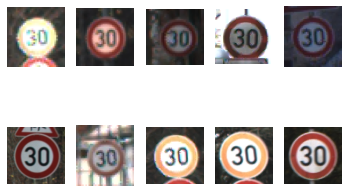

In [36]:
show_images('1')

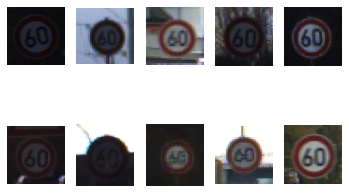

In [37]:

show_images('3')

For loading the dataset we are using 'ImageDataGenerator' which also allows us to
preprocess the images for data augmentation and it also loads the data efficiently
according to your RAM Requirements.It is better for data augmentation purposes. But if you want custom preprocessing or optimization  in data pipeline don't use `ImageDataGenerator`.

Another alternative is `image_dataset_from_directory` which being from`tf.data.Dataset` API allows prefetching/caching/parallising and other cool things if you have a cluster of workstations or multiple GPU's , but on a standard home machine like mine it did not provide much advantage.

Edit: The following dataset is very disk heavy , thus your GPU may not be the bottleneck( the ideal way).. So if you observe the first epoch to be very slow (2-5 mins) don't be shocked. The subsequent epochs are very fast (5-6s) as the data is cached into your RAM.

We are creating three datasets!
* Training (from the 'data/train' directory)
  For training purposes
* Validation (from the 'data/train' directory)
  For validating the performance of model while training
* Testing (from the 'data/test' directory)
  For testing the performance of the model on unseen data
  For giving a lower bound on model's performance.
  Basically Final Testing

In [38]:
# Few Constants before we get started
import os
RANDOM_STATE=0
VALIDATION_SPLIT=0.2
TRAIN_DIR='data/train'
VALIDATION_DIR='data/test'
IMG_HEIGHT=20
IMG_WIDTH=20
EPOCHS=10
# All images are RGB thus R (Red Channel) , G (Green Channel) and B (Blue Channel). 3 Channels
CHANNELS=3
# This depends on your RAM , change for your configuration
BATCH_SIZE=40
# No of labels 
NUM_LABELS=len(os.listdir('data/train')) # 43

In [39]:
# Train Generator
# This acutally does not load the data.
# We simply declare the augmentations to apply on the image
train_generator = tf.keras.preprocessing.image.ImageDataGenerator( validation_split=0.2 , rescale=1/255  )

In [40]:
# Test Generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255  )

In [41]:
from tensorflow.keras import layers
from tensorflow.keras import models

`models.Sequential()` helps defining sequential models. That is each layer is connected to next layer. This does not allow for branches and shorting the model. For more complex models use the Functional inteface.

In [42]:
# model = models.Sequential()

Filters refer to the no of convolutions are initialized. Here 64 is used. The input_shape is important for knowing how many neurons are to be initialized.
If not using `input_shape`use a `Input()` layer.
Kernel Size allows us to define the size of the convolution. A 3x3 convolution will be represented as a 3x3 square which will move over the entire image.
As `padding` is not given output image will be (IMG_HEIGHT-2 , IMG_WIDTH-2) after convolution.
The `relu` activation layer is simple. If input is positive it return the input. If negative return 0.

In [43]:
# model.add(layers.Conv2D(filters=64 , kernel_size=(3,3) , activation='relu' , input_shape=(20,20,3)))

MaxPool Layer pools multiple 2D pixels into one 1x1 pixel.Here 2x2 square is used for pooling.Max Pool selects the max pixel value from the square.

In [44]:
# model.add(layers.MaxPool2D(pool_size=(2,2)))

`Flatten()` converts the 3D data into 1D array.

In [45]:
# model.add(layers.Flatten())

`Dense` is the standard layer of neurons used in Deep Learning.

In [46]:
 # model.add(layers.Dense(units=250 , activation='relu'))

In [47]:
# model.add(layers.Dense(units=100 , activation='relu'))

Having the last layer defined as 'softmax' helps boost the positives and suppress the negatives.Here it should have exactly fixed no of units which corresponds with no of labels. (In this case 43). The loss function that goes with softmax is `crossentropy`

In [48]:
# model.add(layers.Dense(units=NUM_LABELS , activation='softmax'))

Why are you defining the model again ?
The model was declared in a staggerred manner to explain  the decision on each layer.
I personally like to define the model all in one place , this helps in making small modifications and testing multiple variations

In [49]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,3) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=250 , activation='relu'),
    layers.Dense(units=100 , activation='relu'),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5184)              0         
                                                                 
 dense_3 (Dense)             (None, 250)               1296250   
                                                                 
 dense_4 (Dense)             (None, 100)               25100     
                                                                 
 dense_5 (Dense)             (None, 43)                4343      
                                                      

In [80]:
train_datagen = train_generator.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    classes=None,
    target_size=(IMG_HEIGHT , IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    subset='training'
)


Found 31368 images belonging to 43 classes.


In [79]:
validation_datagen = train_generator.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    classes=None,
    target_size=(IMG_HEIGHT , IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    subset='validation'
)

Found 7841 images belonging to 43 classes.


In [53]:
import tensorflow as tf

Compiling the model means setting the optimizer and loss. The ADAM optimizer is good enough , the loss function should be appropriate.
`categorical_crossentropy` is used as no of labels(43) is more than 2(use `binary_crossentropy` if 2).  

The labels are categorized automatically by tensorflow thus we are not using `sparse_categorical_crossentropy`. `Categorizing` the labels meaning converting labels into sparse arrays as it is required if using `softmax` as last layer.

softmax output => [ 0.2 , 0.1 , 0.4 ]
label if not categorized => [2] (Can't be used with softmax-output)
label if categorized => [ 0 , 0 , 1] (Sparse Array)

As you can see the categorized label is directly used with softmax. While non-categorized label has be converted. For conversion use either
`keras.utils.to_categorical` on labels or use `sparse_categorical_crossentropy` as loss function.

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [88]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0299 - acc: 0.9921 - val_loss: 0.9950 - val_acc: 0.8540
Epoch 2/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0290 - acc: 0.9914 - val_loss: 1.1817 - val_acc: 0.8175
Epoch 3/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0189 - acc: 0.9943 - val_loss: 1.1504 - val_acc: 0.8499
Epoch 4/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0339 - acc: 0.9910 - val_loss: 1.0131 - val_acc: 0.8542
Epoch 5/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0187 - acc: 0.9946 - val_loss: 1.0677 - val_acc: 0.8561
Epoch 6/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0242 - acc: 0.9928 - val_loss: 1.3121 - val_acc: 0.8290
Epoch 7/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0244 - acc: 0.9935 - val_loss: 1.4831 - val_acc: 0.8366
Epoch 8/10
785/785 [==============================] - 4s 5ms/step - loss: 0.

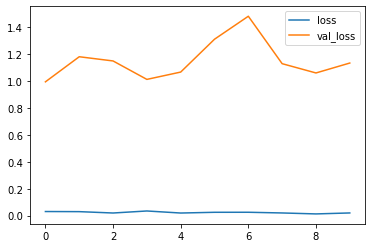

In [89]:
import matplotlib.pyplot as plt
plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

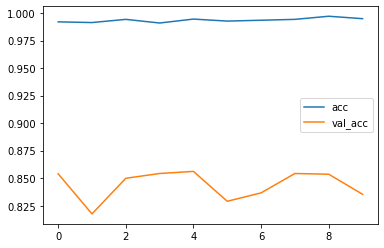

In [90]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

The model currently is overfitting quite badly! It is evident by the fact that training_acc is 99% but validation_acc is 82%.Let's try making them almost similar.

### First Method to prevent Overfitting
Reduce the complexity of the model. It solves the problem most of the time.

In [91]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,3) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=100 , activation='relu'),
    layers.Dense(units=60 , activation='relu'),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [92]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [93]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/10
785/785 [==============================] - 5s 5ms/step - loss: 1.3663 - acc: 0.6337 - val_loss: 0.8514 - val_acc: 0.7647
Epoch 2/10
785/785 [==============================] - 4s 5ms/step - loss: 0.3796 - acc: 0.8954 - val_loss: 0.7121 - val_acc: 0.8160
Epoch 3/10
785/785 [==============================] - 4s 5ms/step - loss: 0.2247 - acc: 0.9377 - val_loss: 0.6346 - val_acc: 0.8439
Epoch 4/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1566 - acc: 0.9567 - val_loss: 0.7103 - val_acc: 0.8331
Epoch 5/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1171 - acc: 0.9670 - val_loss: 0.8502 - val_acc: 0.8259
Epoch 6/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0918 - acc: 0.9731 - val_loss: 0.7384 - val_acc: 0.8374
Epoch 7/10
785/785 [==============================] - 4s 5ms/step - loss: 0.0804 - acc: 0.9762 - val_loss: 0.7879 - val_acc: 0.8415
Epoch 8/10
785/785 [==============================] - 4s 5ms/step - loss: 0.

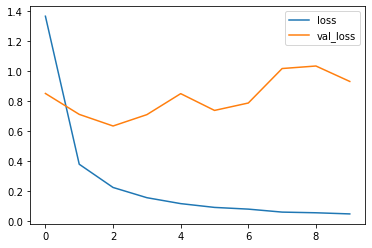

In [94]:

plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

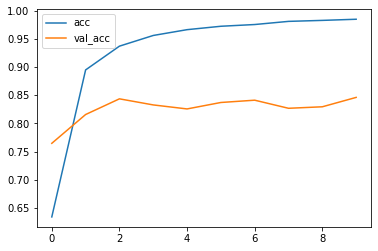

In [95]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

### More accuracy!
Fore increasing the accuracy more. Let's add dropout. Dropout will force the model to learn the data using all the units/neurons thus decreasing overfitting and generalize the data more.

In [96]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,3) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=100 , activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=60 , activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [97]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [98]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/10
785/785 [==============================] - 5s 5ms/step - loss: 1.8048 - acc: 0.4856 - val_loss: 1.0034 - val_acc: 0.6998
Epoch 2/10
785/785 [==============================] - 4s 5ms/step - loss: 0.7302 - acc: 0.7731 - val_loss: 0.6552 - val_acc: 0.8086
Epoch 3/10
785/785 [==============================] - 4s 5ms/step - loss: 0.4869 - acc: 0.8454 - val_loss: 0.5854 - val_acc: 0.8352
Epoch 4/10
785/785 [==============================] - 4s 5ms/step - loss: 0.3741 - acc: 0.8834 - val_loss: 0.5021 - val_acc: 0.8583
Epoch 5/10
785/785 [==============================] - 4s 5ms/step - loss: 0.3131 - acc: 0.9031 - val_loss: 0.5430 - val_acc: 0.8533
Epoch 6/10
785/785 [==============================] - 4s 5ms/step - loss: 0.2697 - acc: 0.9174 - val_loss: 0.4961 - val_acc: 0.8745
Epoch 7/10
785/785 [==============================] - 4s 5ms/step - loss: 0.2383 - acc: 0.9248 - val_loss: 0.5324 - val_acc: 0.8665
Epoch 8/10
785/785 [==============================] - 4s 5ms/step - loss: 0.

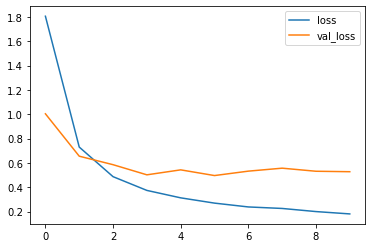

In [99]:

plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

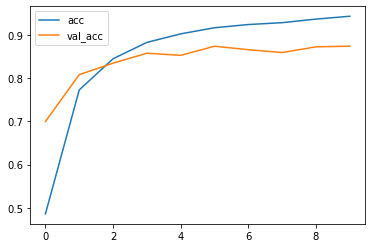

In [100]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

### Adding more Dropout
Adding dropout also means your model learns very slowly thus you may need to train for longer epochs. Let's add a little more dropout and train for 25 epochs

In [111]:
EPOCHS=25

In [112]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,3) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=100 , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=60 , activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [113]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [114]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/25
785/785 [==============================] - 5s 5ms/step - loss: 2.4329 - acc: 0.3185 - val_loss: 1.3909 - val_acc: 0.6087
Epoch 2/25
785/785 [==============================] - 4s 5ms/step - loss: 1.4050 - acc: 0.5567 - val_loss: 0.9086 - val_acc: 0.7544
Epoch 3/25
785/785 [==============================] - 4s 5ms/step - loss: 1.0878 - acc: 0.6482 - val_loss: 0.7265 - val_acc: 0.8058
Epoch 4/25
785/785 [==============================] - 5s 5ms/step - loss: 0.9213 - acc: 0.6992 - val_loss: 0.6699 - val_acc: 0.8014
Epoch 5/25
785/785 [==============================] - 4s 5ms/step - loss: 0.8390 - acc: 0.7241 - val_loss: 0.6082 - val_acc: 0.8157
Epoch 6/25
785/785 [==============================] - 4s 5ms/step - loss: 0.7634 - acc: 0.7503 - val_loss: 0.5544 - val_acc: 0.8489
Epoch 7/25
785/785 [==============================] - 4s 5ms/step - loss: 0.7057 - acc: 0.7674 - val_loss: 0.5520 - val_acc: 0.8398
Epoch 8/25
785/785 [==============================] - 4s 5ms/step - loss: 0.

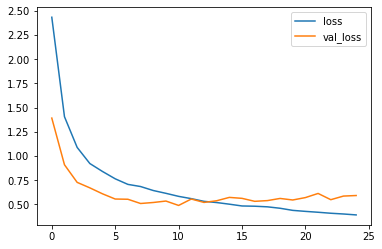

In [115]:

plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

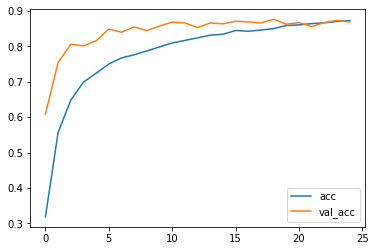

In [116]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

### Models' highest accuracy
The current architectures highest ever accuracy 86% at 25 Epochs. The highest it ever went was 87.34 at 24th epoch , thus we can't use `EarlyStopping` as a method of increasing accuracy as it is too close to terminal epoch.
Now as our training and validation accuracy is very close. We have to increase the capacity of the model.

#### Increasing IMG_HEIGHT and IMG_WIDTH
Increasing the IMG_HEIGHT and IMG_WIDTH means the model can capture more information. A appropriate size would be 40x40. As we have used constants this does not require any modification other than changing the variables.
Another modification is to increase the model's no of convolutional layers as image given is 40x40. This will allow it to capture more information



In [1]:
# Few Constants before we get started
import os
RANDOM_STATE=0
VALIDATION_SPLIT=0.2
TRAIN_DIR='data/train'
TEST_DIR='data/test'
# New Constants
IMG_HEIGHT=40
IMG_WIDTH=40
EPOCHS=15
# All images are RGB thus R (Red Channel) , G (Green Channel) and B (Blue Channel). 3 Channels
CHANNELS=3
# This depends on your RAM , change for your configuration
BATCH_SIZE=40
# No of labels 
NUM_LABELS=len(os.listdir('data/train')) # 43

In [2]:
import tensorflow as tf

In [3]:
# Train Generator
# This acutally does not load the data.
# We simply declare the augmentations to apply on the image
train_generator = tf.keras.preprocessing.image.ImageDataGenerator( validation_split=0.2 , rescale=1/255  )

In [4]:
# Test Generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255  )

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [6]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=32 , activation='relu' , input_shape=(IMG_HEIGHT , IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=100 , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=75 , activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

2022-02-07 10:36:41.345486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 10:36:41.448239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 10:36:41.448391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 10:36:41.448977: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               2

In [8]:
train_datagen = train_generator.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    classes=None,
    target_size=(IMG_HEIGHT , IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    subset='training'
)


Found 31368 images belonging to 43 classes.


In [9]:
validation_datagen = train_generator.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    classes=None,
    target_size=(IMG_HEIGHT , IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    subset='validation'
)

Found 7841 images belonging to 43 classes.


In [10]:
import tensorflow as tf

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [12]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/15


2022-02-07 10:36:55.302374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


785/785 [==============================] - ETA: 0s - loss: 2.4559 - acc: 0.294 - 133s 163ms/step - loss: 2.4518 - acc: 0.2958 - val_loss: 1.3394 - val_acc: 0.5724
Epoch 2/15
785/785 [==============================] - 28s 35ms/step - loss: 1.2429 - acc: 0.5850 - val_loss: 0.7628 - val_acc: 0.7877
Epoch 3/15
785/785 [==============================] - 11s 13ms/step - loss: 0.8729 - acc: 0.7088 - val_loss: 0.5401 - val_acc: 0.8424
Epoch 4/15
785/785 [==============================] - 12s 14ms/step - loss: 0.6999 - acc: 0.7623 - val_loss: 0.4188 - val_acc: 0.8819
Epoch 5/15
785/785 [==============================] - 12s 15ms/step - loss: 0.6069 - acc: 0.7948 - val_loss: 0.3284 - val_acc: 0.9185
Epoch 6/15
785/785 [==============================] - 10s 13ms/step - loss: 0.5402 - acc: 0.8190 - val_loss: 0.3129 - val_acc: 0.9133
Epoch 7/15
785/785 [==============================] - 11s 13ms/step - loss: 0.4884 - acc: 0.8365 - val_loss: 0.2773 - val_acc: 0.9288
Epoch 8/15
785/785 [=============

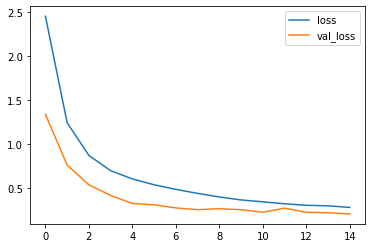

In [13]:
import matplotlib.pyplot as plt
plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

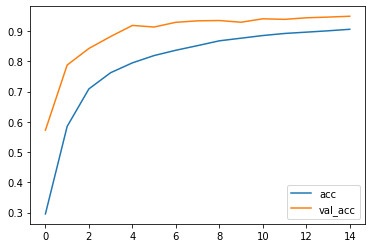

In [14]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

## 94% from 86%
Increasing the image size and complexity of the model took it from 86% initially to 94%! More trial and error is done below (like increasing EPOCHS and model complexity).

In [178]:
EPOCHS = 25

In [179]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=32 , activation='relu' , input_shape=(IMG_HEIGHT , IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=100 , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=75 , activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [180]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [181]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/25
785/785 [==============================] - 11s 12ms/step - loss: 2.4443 - acc: 0.3022 - val_loss: 1.4338 - val_acc: 0.5538
Epoch 2/25
785/785 [==============================] - 10s 12ms/step - loss: 1.2133 - acc: 0.6061 - val_loss: 0.8144 - val_acc: 0.7630
Epoch 3/25
785/785 [==============================] - 10s 12ms/step - loss: 0.8424 - acc: 0.7244 - val_loss: 0.6097 - val_acc: 0.8286
Epoch 4/25
785/785 [==============================] - 10s 13ms/step - loss: 0.6844 - acc: 0.7770 - val_loss: 0.5182 - val_acc: 0.8471
Epoch 5/25
785/785 [==============================] - 10s 13ms/step - loss: 0.5905 - acc: 0.8069 - val_loss: 0.5326 - val_acc: 0.8507
Epoch 6/25
785/785 [==============================] - 11s 14ms/step - loss: 0.5347 - acc: 0.8282 - val_loss: 0.4150 - val_acc: 0.8785
Epoch 7/25
785/785 [==============================] - 9s 11ms/step - loss: 0.4735 - acc: 0.8459 - val_loss: 0.4060 - val_acc: 0.8815
Epoch 8/25
785/785 [==============================] - 10s 12ms/

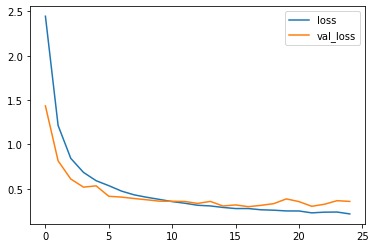

In [182]:
import matplotlib.pyplot as plt
plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

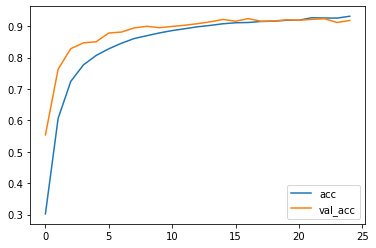

In [183]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

## Increasing Model Complexity
Although our model is overfitting a little(training acc is 93% while validation acc is 91%) .. For now I will increase complexity of model

In [ ]:
model = models.Sequential([
    layers.Conv2D(filters=64 , activation='relu' , input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=32 , activation='relu' , input_shape=(IMG_HEIGHT , IMG_WIDTH,CHANNELS) , kernel_size=(3,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=150 , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=100, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=50 , activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=NUM_LABELS , activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['acc'])

In [ ]:
history = model.fit(train_datagen , validation_data=validation_datagen  ,use_multiprocessing=True , workers=15 , epochs=EPOCHS)

Epoch 1/25
785/785 [==============================] - 11s 13ms/step - loss: 2.5184 - acc: 0.2751 - val_loss: 1.4956 - val_acc: 0.5184
Epoch 2/25
785/785 [==============================] - 12s 14ms/step - loss: 1.2916 - acc: 0.5662 - val_loss: 0.8848 - val_acc: 0.7498
Epoch 3/25
785/785 [==============================] - 11s 14ms/step - loss: 0.8457 - acc: 0.7203 - val_loss: 0.6225 - val_acc: 0.8352
Epoch 4/25
785/785 [==============================] - 10s 12ms/step - loss: 0.6506 - acc: 0.7862 - val_loss: 0.4845 - val_acc: 0.8649
Epoch 5/25
785/785 [==============================] - 11s 14ms/step - loss: 0.5423 - acc: 0.8240 - val_loss: 0.4453 - val_acc: 0.8828
Epoch 6/25
785/785 [==============================] - 12s 14ms/step - loss: 0.4616 - acc: 0.8519 - val_loss: 0.3584 - val_acc: 0.9018
Epoch 7/25
785/785 [==============================] - 12s 14ms/step - loss: 0.4143 - acc: 0.8681 - val_loss: 0.3705 - val_acc: 0.9115
Epoch 8/25
785/785 [==============================] - 10s 12ms

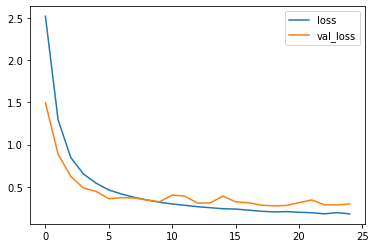

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(EPOCHS)) , history.history['loss'] , label='loss')
plt.plot(list(range(EPOCHS)) , history.history['val_loss'] , label='val_loss')
plt.legend()

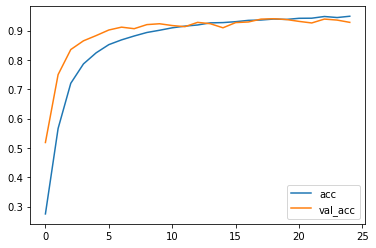

In [ ]:
plt.plot(list(range(EPOCHS)) , history.history['acc'] , label='acc')
plt.plot(list(range(EPOCHS)) , history.history['val_acc'] , label='val_acc')
plt.legend()

## Using testing dataset
Now that we have trained our model to quite a high degree. We can try the model with some testing data. The data that the model has never seen before(data stored in 'data/test' directory).The data stored there is not divided using directories. So a simple script is used for that exact reason.

In [20]:
# Creating custom subfolders in 'data/custom_train_dir/{subfolders}'
import os
if not os.path.isdir('data/custom_test_dir'):
    os.mkdir('data/custom_test_dir')
    
for i in range(43):
    dirpath = os.path.join('data','custom_test_dir')
    path = os.path.join(dirpath,str(i))
    if not os.path.isdir(path):
        os.mkdir(path)

In [19]:
import csv
import os
labels = set()

with open('data/Test.csv') as testfile:
    csvFile = csv.reader(testfile)
    
    
    for line in csvFile:
        classID = line[-2]
        labels.add(classID)
        Path = line[-1]
print(labels)

{'40', '34', '8', '41', '37', '26', '16', '39', '13', '6', '0', '27', '22', '32', '25', '4', '10', '31', '14', '38', 'ClassId', '5', '3', '17', '28', '11', '12', '9', '20', '2', '36', '24', '42', '21', '30', '23', '33', '15', '29', '7', '1', '35', '18', '19'}


As the labels are from 0-42 we can simply move the file into respective dir.

In [21]:
import os
import csv
with open('data/Test.csv') as testfile:
    csvFile = csv.reader(testfile)
    # Skip the first line
    next(csvFile)
    for line in csvFile:
        classID = line[-2]
        Path = line[-1]
        srcpath = os.path.join('data',Path)
        parentdir = os.path.join('data' , 'custom_test_dir')
        destdir = os.path.join(parentdir,str(classID))
        filename = os.path.basename(Path)
        destpath = os.path.join(destdir,filename)
        os.rename(srcpath,destpath)
        

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_generator = ImageDataGenerator(rescale=1/255)

In [16]:
test_datagen = test_generator.flow_from_directory(
    'data/custom_test_dir',
    class_mode='categorical',
    classes=None,
    color_mode='rgb',
    target_size=(IMG_HEIGHT,IMG_WIDTH),
)

Found 12630 images belonging to 43 classes.


In [18]:
model.evaluate(test_datagen)

395/395 [==============================] - 3s 8ms/step - loss: 0.2444 - acc: 0.9420


[0.24437253177165985, 0.9420427680015564]

### Testing accuracy of 94%
This has proved that our current model achieves a lot!. We have just started.Although we can do a lot more, I think this shows how standard machine learning works and provides a good starting poing for tweaking the model more.
Techniques that you can use:
* Transfer Learning
    Use models like VGG19 , ResNET or other for a base and use transfer-learning for more accuracy.But requires quite a lot of GPU Power.
* Data augmentation
    Although we did not use any data augmentation , we do not need to edit nothing more than parameters of `ImageDataGenerator` as it is designed with data augmentation in mind.
    See the documentation for some parameter edits for simple data augmentation.
* Larger models
    This simply is useful but can lead to huge amount of overfitting. Try to increase gradually.